## Setup: Libraries y Data reading





In [ ]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np
import json
from tqdm.notebook import tqdm_notebook
import glob
import datetime

#Import from drive
from google.colab import drive
drive.mount('/content/gdrive/')

#folder with the data: link: https://drive.google.com/drive/folders/1Gk7LPNdZkYSTnOLOpqlNzwKQ1IqQo6Io?usp=sharing
como_se_llama_mi_carpeta= 'data_proyecto/'
root_path = '/content/gdrive/MyDrive/' + como_se_llama_mi_carpeta



'''
#Import from pc
root_path=''
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
'''

In [ ]:
#Read the data
def read_data(stores):
  networks = []
  distances = [] 
  orders = []
  resources = []

  for day in ['1','2','3','4','5','6']:
    networks.append(pd.read_csv(root_path+'instance-'+stores+'-b-day'+day+'_network.txt', sep=';', header=None, comment='#', index_col= 1, skiprows = [i for i in range(103,10306)]))
    distances.append(pd.read_csv(root_path+'instance-'+stores+'-b-day'+day+'_network.txt', sep=';', header=None, comment='#', index_col=1, skiprows = [i for i in range(0,103)]))
    orders.append(pd.read_csv(root_path+'instance-'+stores+'-b-day'+day+'_orders.txt', sep=';', header=None, comment='#', index_col=1))
    resources.append(pd.read_csv(root_path+'instance-'+stores+'-b-day'+day+'_resources.txt', sep=';', header=None, comment='#', index_col=1))
  
  return networks, distances, orders, resources


## Defining functions we will be using

In [ ]:
#Tiempo-Costo
#Devuelve matrices de tiempo y costo para el viaje entre tiendas que se deben visitar en el dia
#La entrada i,j de la matriz costo y tiempo nos da, respectivamente, el costo y tiempo asociado al viaje del lugar i al lugar j

def costo_tiempo(distances,dia,orders):
  tiendas_dia =np.unique(orders[dia][4]) #nos da la lista de tiendas a visitar en el dia  
  N_ordenes= len(tiendas_dia)
  costo=np.zeros((N_ordenes,N_ordenes),dtype=int)
  tiempo=np.zeros((N_ordenes,N_ordenes),dtype=int)

  for i in range(len(distances[dia][0])):
    if distances[dia][3][i] in tiendas_dia and distances[dia][5][i] in tiendas_dia:
      index1=np.where(tiendas_dia == distances[dia][3][i])[0][0]
      index2=np.where(tiendas_dia == distances[dia][5][i])[0][0]
      costo[index1][index2]=   distances[dia][7][i]
      tiempo[index1][index2]=  distances[dia][8][i] * 60
  return costo, tiempo



In [ ]:
#Ordenes
#Devuelve listas de pickups y deliveries. Formato: = [lugar, [comidas], penalty]

def order_list(dia,orders):
  tiendas_dia =np.unique(orders[dia][4]) #ubica unicamente las tiendas que se van a visitar
  #print(np.unique(orders[dia][4]))
  N_orders=len(orders[dia][0]) #Numero de ordenes del dia
  pickups=[]
  deliveries=[]
  for i in range(N_orders):
      if orders[dia][6][i]>0: #Es un Pickup. 
        #convertir string de orden en vector
        comida=orders[dia][5][i].split(' ')
        for j in range (0,3):
          comida[j]=int(comida[j])
        a=np.where(tiendas_dia == orders[dia][4][i])[0][0]             
        pickups.append([a, comida , orders[dia][7][i]])
      else:
        #convertir string de orden en vector
        comida=orders[dia][5][i].split(' ')
        for j in range (0,3):
         comida[j]=int(comida[j])
        a=np.where(tiendas_dia == orders[dia][4][i])[0][0]  
        deliveries.append([a, comida , orders[dia][7][i] ])
  return pickups,deliveries, tiendas_dia


In [ ]:
#Defining classes Trucks and Stores

DAY = 64800 #(De 2AM a 8PM = 18H = 64800seg)
FRESH_TIME = 18000 #(7AM)

class Truck:
  def __init__(self, index, home_loc, current_loc, next_loc, must_use, usage_fee, time = 32400, fresh = 0, frozen = 0, uncooled = 0, orders = [], activity = 0, T_activity = 0, GT = DAY, turn = 0):
    self.id = index #index number in table
    self.home = home_loc #home loaction in table
    self.loc = current_loc #current loaction
    self.next = next_loc #next location
    self.use = must_use #must use from
    self.fee = usage_fee #usage fee from table
    self.time = time #use time left of truck
    self.gol = GT #Global time
    self.fresh = fresh #free space for fresh food
    self.frozen = frozen #free space for frozen food
    self.uncooled = uncooled #free space for uncooled food
    self.orders = [] #list of orders in a day
    self.activitiy = activity #type of activity loading=0 ,  moving=1, unloading = 2 o stopped = 3.
    self.T_activity = T_activity #time activity occurs
    self.turn = turn #the truck starts at 2am or at 11am


  def __repr__(self):
    return f'{self.id}: {self.loc}: {self.time}' #displayed info when class is called

class Store:
  def __init__(self, name, D_fresh, D_frozen, D_uncooled, P_fresh, P_frozen, P_uncooled, time, orders, has_truck = False):
    self.name = name #index of the name of store from list of stores to visit 
    self.has_truck = has_truck #boolean is there is a truck
    self.D_fresh = D_fresh #fresh food need from delivery
    self.D_frozen = D_frozen #frozen food needed from delivery
    self.D_uncooled = D_uncooled #uncooled food needed from delivery
    self.P_fresh = P_fresh #fresh food pick up
    self.P_frozen = P_frozen #frozen food pickup
    self.P_uncooled = P_uncooled #uncooled food pickup
    self.time = time #time to reach store and deliver
    self.orders= [] 

  def __repr__(self):
    return f'{self.name}: {self.has_truck}: {self.time}' #displayed info when class is called

In [ ]:
#Generates trucks from the availabe resources 

def generate_trucks(dia, resources,orders):
  Available= len(resources[dia][0])
  #Crear objetos clase Truck
  trucks=[]
  stores_day =np.unique(orders[dia][4])
  for i in range(Available):
    index1= np.where(stores_day == resources[dia][5][i] )[0][0]
    camioncito=Truck(i,index1,index1, resources[dia][7][i],  resources[dia][8][i],0)  #colocar arrival = 0
    camioncito.orders=[]
    trucks.append(camioncito)
  return trucks



In [ ]:
def travel(Truck,order,costo,tiempo):
  #dados un camion y su proxima localizacion cambia el tiempo de actividad y el usage fee
  Truck.T_activity+= tiempo[Truck.loc][order[0]]
  Truck.fee+= costo[Truck.loc][order[0]]
  Truck.activity=1 #el camion se esta moviendo
  Truck.loc=order[0]
  #Store.has_truck=True #theres a truck in this store


In [ ]:
def load(Truck, Order,tiempo,costo): #order must be delivery!!
  if Truck.fresh - Order[1][0] == 0 or  Truck.uncooled - Order[1][1] == 0 or  Truck.frozen - Order[1][2] == 0:
    if Truck.fresh - Order[1][0]<= 33 and Truck.uncooled - Order[1][1] <= 33 and Truck.frozen - Order[1][2] <= 33:
      time_av= Truck.T_activity +  tiempo[Truck.loc][Order[0]]+ tiempo[Order[0]][Truck.home] + 900
      if time_av < Truck.time: #Checks if the truck has time to go to the location and return home.
        travel(Truck,Order,costo,tiempo) #updates location and remaning time  after acepting the order
        #adds food 
        
        Truck.fresh -= Order[1][0]
        Truck.uncooled -= Order[1][1]
        Truck.frozen -= Order[1][2]
        Truck.orders.append(Order) #adds a new mission to the truck driver!
        return 0
      else:
        return 1
    else:
      return 1
  else:
    return 1


In [ ]:
def itinerary(dia,resources,orders,distances,ramps, AM_Trucks): #ramps is the number of trucks that can be loaded simultaneously in the warehouse
  #initialization. Cantidad de Trucks que saldran en la ma{ana}
  
  pickup,delivery,Store_list= order_list(dia,orders)
  cost, time = costo_tiempo(distances,dia,orders)
  #print(len(time[0]))
  Trucks=generate_trucks(dia,resources,orders)
  #print(Trucks[0].orders)
  #print(len(delivery))
  #separate fresh food from the orders
  fresh_pickup,fresh_delivery=[],[]

  def discriminador(pickup):
    if pickup[:][1][0]!=0:
      return True
    False 

  fp_ite=filter( discriminador , pickup  )
  fresh_pickup=list(fp_ite)  #separate fresh pickups
  for i in range(len(fresh_pickup)):
    pickup.remove(fresh_pickup[i]) #remove fresh pickups from the list (because they are accounted in another list)
  
  fp_ite1=filter( discriminador , delivery  )
  fresh_delivery=list(fp_ite1) #separate fresh deliveries
  #print(fresh_delivery)
  for i in range(len(fresh_delivery)):
    delivery.remove(fresh_delivery[i]) #remove fresh deliveries from the list (because they are accounted in another list)
  #print(len(fresh_pickup),len(pickup),len(fresh_delivery),len(delivery))
  
  #it's now time to separate the trucks!

  if AM_Trucks == len(Trucks): #All the Trucks are morning Trucks
    pass

  else:
    for T in range (AM_Trucks, len(Trucks)): #put the rest of the trucks as PM_Trucks
      Trucks[T].turn = 1


  #truck loading 
  contador = 0 #number of loaded trucks
  k=0 #last batch of trucks loaded 
  #fail=0 #number of unsucesful loadings 
  #matrices de conflictos
  N_misiones = len(fresh_delivery)+len(delivery)

  '''
  Le_times = np.zeros( (N_misiones, N_misiones), dtype= int)
  Le_sites = np.zeros( (N_misiones, N_misiones), dtype= int)
  Le_conflictos = np.zeros( (N_misiones, N_misiones), dtype= int)
  '''

  Le_times= [[0]*N_misiones for i in range(len(Trucks))]
  Le_sites= [[0]*N_misiones for i in range(len(Trucks))]
  Le_conflictos= [[0]*N_misiones for i in range(len(Trucks))]
  
  #HERE IS WHERE WE LOAD THE TRUCKS
 
  for i in range( len(Trucks)):
    contador+=1 # the truck has been  loaded 

    if contador % ramps==0: 
      for j in range(k,len(Trucks)):
        if Trucks[i].turn == Trucks[j].turn:
          Trucks[j].T_activity+=900 #15 min for charging trucks on the ramps   
        else:
          pass
      k+=ramps
    

    if i == len(Trucks)-1: #idea de mario
      t=len(Trucks)%ramps
      if t == 0:
        pass
      else:
        for j in range(k,len(Trucks)):
          if Trucks[i].turn == Trucks[j].turn:         
            Trucks[j].T_activity+=900
          else:
            pass

    
    #priority: fresh food

    if Trucks[i].turn == 0: #Only AM_trucks can load fresh foods!

      for t in range(len(fresh_delivery)**2):  #this is long story but trust me on this one 
        #random truck from the list of available trucks
        #to_load=np.random.randint(0, high=len(Trucks), dtype=int)
        #random order from the fresh pickup list
        if len(fresh_pickup)==0:
          break
        
        to_be_loaded= np.random.randint(0, high=(len(fresh_pickup)), dtype=int)
        
        if Trucks[i].T_activity + time[Trucks[i].loc][fresh_delivery[to_be_loaded][0]] <= 18000: #The truck can make the fresh_delivery before 7AM

          a=load(Trucks[i],fresh_delivery[to_be_loaded],time,cost) 
          #print(to_be_loaded)
          if a==1: #the order could not be loaded
            #fail+=1
            pass
          else: #the order was loaded 
            if i == 0:
              Le_times[i][len(Trucks[i].orders)] = Trucks[i].T_activity
              Le_sites[i][len(Trucks[i].orders)] = Trucks[i].loc
              fresh_pickup.pop(to_be_loaded)
              #Number_of_mission += 1
            else:
              #print('i',Trucks[i].T_activity)
              Le_times[i][len(Trucks[i].orders)] = Trucks[i].T_activity
              Le_sites[i][len(Trucks[i].orders)] = Trucks[i].loc
              flag=0
              for p in range(len(Trucks[i].orders)):
                for q in range(i):
                  if Le_times[i][len(Trucks[i].orders)] != 0 and Le_sites[i][len(Trucks[i].orders)] != 0: #we do not count conflicts in the warehouse
                    if Le_times[i][len(Trucks[i].orders)] == Le_times[q][p] and Le_sites[i][len(Trucks[i].orders)] == Le_sites[q][p] and Trucks[i].turn == Trucks[q].turn:
                      Le_conflictos[q][p] += 1
                      if Trucks[i].T_activity + (900 * Le_conflictos[q][p]) +  time[Trucks[i].loc][Trucks[i].home] + 900 <= Trucks[i].time: #i can wait en la cola
                        Trucks[i].T_activity +=  900 * Le_conflictos[q][p]
                        
                        #fresh_pickup.pop(to_be_loaded)
                        #Number_of_mission += 1

                      else: #I cant afford to wait 15 min
                        flag=1 #trust me on this one
                        Le_times[i][len(Trucks[i].orders)] = 0
                        Le_sites[i][len(Trucks[i].orders)] = 0
                        Trucks[i].fresh +=fresh_delivery[to_be_loaded][1][0]
                        Trucks[i].uncooled += fresh_delivery[to_be_loaded][1][1]
                        Trucks[i].frozen +=fresh_delivery[to_be_loaded][1][2]
                        #if tiempo[Trucks[i].orders[-1][0]][Trucks[i].loc] == 0:
                        if len(Trucks[i].orders)==1 : #is the only order 
                          Trucks[i].T_activity = Trucks[i].T_activity - time[0][Trucks[i].loc]
                          Trucks[i].loc=0
                          Trucks[i].fee -= time[0][Trucks[i].loc] 
                        else:
                          Trucks[i].T_activity = Trucks[i].T_activity - time[Trucks[i].orders[-1][0]][Trucks[i].loc]
                          Trucks[i].loc=Trucks[i].orders[-1][0]
                          Trucks[i].fee-= time[Trucks[i].orders[-1][0]][Trucks[i].loc] 
                        Trucks[i].activity=0
                        Trucks[i].orders.remove(fresh_delivery[to_be_loaded])
                        
              
              #print('range',len(fresh_pickup),to_be_loaded)
              if flag==1:
                pass
              else:
                Le_times[i][len(Trucks[i].orders)] = Trucks[i].T_activity
                fresh_pickup.pop(to_be_loaded)
              #print('f',Trucks[i].T_activity) 
        
        else: #the truck cannot make the delivery before 7AM
          pass       
                    

    #rest of the food
    for g in  range(len(delivery)**2): #this is long story but trust me on this one
        #random truck from the list of available trucks
        #to_load=np.random.randint(0, high=len(Trucks), dtype=int)
        #random order from the fresh pickup list
        if len(pickup)==0:
          break
        to_be_loaded= np.random.randint(0, high=(len(pickup)), dtype=int)
        a=load(Trucks[i],delivery[to_be_loaded],time,cost) 
        #print(to_be_loaded)
        if a==1: #the order could not be loaded
          #fail+=1
          pass
        else: #the order was loaded
          if i == 0:
            Le_times[i][len(Trucks[i].orders)] = Trucks[i].T_activity
            Le_sites[i][len(Trucks[i].orders)] = Trucks[i].loc
            pickup.pop(to_be_loaded)
            #Number_of_mission += 1
          else:
            
            Le_times[i][len(Trucks[i].orders)] = Trucks[i].T_activity
            Le_sites[i][len(Trucks[i].orders)] = Trucks[i].loc
            flag=0
            for p in range(len(Trucks[i].orders)):
              for q in range(i):
                if Le_times[i][len(Trucks[i].orders)] != 0 and Le_sites[i][len(Trucks[i].orders)] != 0: #we do not count conflicts in the warehouse
                  if Le_times[i][len(Trucks[i].orders)] == Le_times[q][p] and Le_sites[i][len(Trucks[i].orders)] == Le_sites[q][p] and Trucks[i].turn == Trucks[q].turn:
                    Le_conflictos[q][p] += 1
                    if Trucks[i].T_activity + (900 * Le_conflictos[q][p]) +  time[Trucks[i].loc][Trucks[i].home] + 900 <= Trucks[i].time: #i can wait en la cola
                      Trucks[i].T_activity +=  900 * Le_conflictos[q][p]
                      
                      #Number_of_mission += 1

                    else: #I cant afford to wait 15 min
                      flag=1
                      Le_times[i][len(Trucks[i].orders)] = 0
                      Le_sites[i][len(Trucks[i].orders)] = 0
                      Trucks[i].fresh +=delivery[to_be_loaded][1][0]
                      Trucks[i].uncooled += delivery[to_be_loaded][1][1]
                      Trucks[i].frozen +=delivery[to_be_loaded][1][2]
                      #if tiempo[Trucks[i].orders[-1][0]][Trucks[i].loc] == 0:
                      if len(Trucks[i].orders)==1 : #is the only order 
                        Trucks[i].T_activity-= time[0][Trucks[i].loc]
                        Trucks[i].loc=0
                        Trucks[i].fee -= time[0][Trucks[i].loc] 
                      else:
                        Trucks[i].T_activity = Trucks[i].T_activity- time[Trucks[i].orders[-1][0]][Trucks[i].loc]
                        Trucks[i].loc=Trucks[i].orders[-1][0]
                        Trucks[i].fee-= time[Trucks[i].orders[-1][0]][Trucks[i].loc] 
                      Trucks[i].activity=0
                      Trucks[i].orders.remove(delivery[to_be_loaded])
            if flag==1:
              pass
            else:
              Le_times[i][len(Trucks[i].orders)] = Trucks[i].T_activity
              pickup.pop(to_be_loaded)
                    
  #for j in range(k,len(Trucks)):
   # Trucks[j].T_activity+=900 #15 min for charging trucks on the ramps
                    
  #return home mission
  for l in range(len(Trucks)):
    travel(Trucks[l],[Trucks[l].home,[0,0,0],0],cost,time)
    Le_times[l][len(Trucks[l].orders)+1] = Trucks[l].T_activity 

  #We remove null entries in the trucks itinerary matrix for storage
  Hourlist=[] #Truck Itinerary with times of arrival to each place
  SitesList=[] #Truck Itinerary with sites of arrival to each place
  for i in range(len(Le_times)):
    Hourlist.append(list(filter(lambda a: a != 0, Le_times[i])))
  #We also change the indicators of each store and use their names instead for data analysis purposes later
  for i in range(len(Le_sites)):
    clean=list(filter(lambda b: b != 0, Le_sites[i]))
    SitesList.append([Store_list[clean[j]] for j in range(len(clean)) ])
  
  for s in range(len(Trucks)):
    if len(Trucks[s].orders) == 0:
      Trucks[s].T_activity = 0

  return fresh_pickup,fresh_delivery,pickup,delivery, Trucks , Hourlist , SitesList



## Monte Carlo

In [ ]:
#instance: number of stores. This set the scenario
#iteration: numbers of Monte Carlo iterations
#schedule: number of days. In out problem is 6

'''
Cheat sheet for 'Route Generation' output array:
given a particular iteration of the MC and a day:
Resultados[iteration][day][0]: total_penalty of the day
Resultados[iteration][day][1]: total cost of all trucks of the day
Resultados[iteration][day][2]: list of the usage fee (cost) of each truck in the day
Resultados[iteration][day][3]: List of itinerary for each truck (each item in this list is a list of orders)
Resultados[iteration][day][4]: LIst of the times remaining for each truck.
'''

def Route_Generation(instance, iteration, schedule, AM_trucks ): #la que tal
  networks1, distances1,orders1,resources1= read_data(instance) #read the data for the desired instance
  #Define number of ramps available in the warehouse for this instance
  cost, time1 = costo_tiempo(distances1,0,orders1)
  
  if instance=='10':
    ramps=5
  elif instance=='25':
    ramps=15
  elif instance=='70':
    ramps=25
  
  #Montecarlo Iterations
  #Array with itinerary necesarry information:
  Results_to_df= [] #Results[cycle]
  Results_to_sch=[] #to give the optimal route
  
  for cycle in tqdm_notebook(range(iteration)):
    res_day=[[]*5 for i in range(schedule)] #(total penalty, total_cost, [truck costs], [truck itinerary], [truck remaining time] ) This has the information for each day in the schedule
    res_days_che= [[]*2 for i in range(schedule)]
    for day in range(schedule):
      #for each day in the schedule, we generate an itinerary for the available trucks
      remaining=[0,0,0,0] #we store the non completed orders 0: fresh pickuops, 1: fresh deliveries, 2: pickups, 3: deliveries
      remaining[0], remaining[1], remaining[2], remaining[3], truck_schedules,hour_list,site_list= itinerary(day,resources1,orders1,distances1,ramps, AM_trucks)

      #First, we wish to know the penalty for this route, for this, we add the penalties in the list of remaining orders
      total_penalty=0
      for i in [0,2]:
        if len(remaining[i])!=0: #if there are incomplete orders
          for j in range(len(remaining[i])):
            total_penalty+=remaining[i][j][2]

      


      #Now we wish to know: 
      total_cost=0  # total cost of the route
      truck_costs=[] #list for the usage fee of each truck
      truck_itinerary=[] # list of each truck's itinerary 
      truck_time= [] #reamining work time for each truck.
      
      for i in range(len(truck_schedules)):
        total_cost+= truck_schedules[i].fee
        site_list[i].append(0) #add the warehouse as last location
        truck_itinerary.append([[hour_list[i][j], site_list[i][j]] for j in range(len(hour_list[i]))]) #truck,sites and time.
        truck_costs.append(truck_schedules[i].fee)    
        truck_time.append(truck_schedules[i].T_activity) #last time of hour_list gives activity time for each truck
      #print('aqui')
      truckcitos= [total_penalty, total_cost, truck_costs,truck_itinerary, truck_time]
      trucksitos_sche=[truck_itinerary, truck_schedules]
      res_day[day]= truckcitos
      res_days_che[day]=trucksitos_sche


    #Storing data:
    Results_to_df.append(res_day)
    Results_to_sch.append(res_days_che)
    

  return Results_to_df, Results_to_sch




## Data Visualization

In [ ]:

def data_vis(iteration,Resultados):
  #Data Frame with the results of monte carlo simulation
  data = np.array([Resultados[j][i] for j in range(iteration) for i in range(6)])


  index_iteration = ['iteration '+str(x+1) for x in range(iteration)]
  index_day = ['day '+str(i+1) for i in range(6)]

  Variables=['Total Penalty', 'Total Cost', 'Usage fee per truck', 'Itinerary' ,'Remaining Activity' ]
  multi_index = pd.MultiIndex.from_product([index_iteration, index_day], names=['iteration','day'])
  Data_frame_Resultados = pd.DataFrame(data, columns=Variables, index=multi_index)

  #Data_frame_Resultados_stacked = Data_frame_Resultados.stack()
  
  path='/content/gdrive/MyDrive/' #will save a copy of the dataframe with all the results 
  name_string='results_dataframe.csv'
  Data_frame_Resultados.to_csv( name_string,mode='a',header=False)
  #Data_frame_Resultados.to_csv( name_string, mode='a',header=False)

  return Data_frame_Resultados


In [ ]:
#show the schedule: 

def itineraryyyyy_gen(array):
  #iteracion/dia/listas de ordenes de camiones/l del camion camion/orden/loc
  #iteracion/dia/camiones/

  days=[]
  for day in range(6):
    trucks=array[day][1]
    #print(trucks)
    site_list=array[day][0]
    #print(site_list)
    hours= array[day][0]
    #print(hours)
    index_day=['day'+str(day+1) ]
    index_truck=['Truck No. ' + str(trucks[i].id) for i in range(len(trucks))] #indexes by truck

    #decoding the time matrix
    for i in range(len(trucks)):
      for j in range(len(trucks[i].orders)):
        hours[i][j][0]=hours[i][j][0]/3600  #turn into hours
        if trucks[i].turn==1:
          hours[i][j][0]+=11 #changes the time for the turns
        elif trucks[i].turn==0:
          hours[i][j][0]+=2 

    #print(hours[1][1])

    data=[[] for k in range(len(trucks))]
    for i in range(len(trucks)):
      for j in range(len(trucks[i].orders)):
        data[i].append([hours[i][j][1], str( datetime.timedelta(hours=hours[i][j][0])), trucks[i].orders[j][1]])
    days.append(data)
    
                  
  return days





In [ ]:

def separate(interesting_files):
  ini,fin=1,6
  string=[]
  df=[]
  Ite=0

  for j in tqdm_notebook(range(1)):
    #print('read')
    df= pd.read_csv(interesting_files)
    #N_ite= int((df.shape[0])/6)
    #print(N_ite)
    for i in tqdm_notebook(range(1)):
      rows_to_keep=[]
      rows_to_keep=np.linspace(ini,fin,num= 6,endpoint=True,dtype=int)
      try:
        string.append(pd.read_csv(interesting_files[j], skiprows = lambda x: x not in rows_to_keep, header=None, sep = ',' ))  
        ini+=6
        fin+=6
      except pd.errors.EmptyDataError: #this is in case one file is corrupted
       pass
    print('aqui')
    Ite+=N_ite 
  return string 



In [ ]:
def histograms(string):
  #Preliminary Calculations
  Total_cost_perw=[string[i][3].sum() for i in range(len(string))]
  Total_penalty_perw=[string[i][2].sum() for i in range(len(string))]
  #print(Total_cost_perw)
  #Decoding the time remaining per truck
  Time_av=[string[i][6].apply(json.loads) for i in range(len(string))]


  #Mean usage per Truck (counting the 0's)
  week_truck_usage_T=[] 
  for i in range(len(Time_av)): #iterations
    sum=0
    for j in range(6): #number of days per iteration
      for k in range(len(Time_av[i][j])): #Trucks on a day
        sum += Time_av[i][j][k]
    sum=sum/(6*len(Time_av[i][j]))
    week_truck_usage_T.append(sum/3600)

  #print(week_truck_usage_T)
  #List of non zero entries
  T_used=[[list(filter(lambda a: a != 0, Time_av[j][i])) for i in range(len(Time_av[j]))] for j in range(len(Time_av))  ]

  week_truck_usage_Non0=[] #
  for i in range(len(T_used)): #iterations
    N=0
    sum=0
    for j in range(6): #number of days per iteration
      for k in range(len(T_used[i][j])): #Trucks on a day
        sum += Time_av[i][j][k]
      N+=len(T_used[i][j])
    sum=sum/N
    week_truck_usage_Non0.append(sum/3600)

  #print(week_truck_usage_Non0)
  N_used=[ [len(T_used[j][i]) for i in range(len(T_used[j])) ] for j in range(len(T_used))  ] #number of trucks used on each day 

  #Mean number of trucks used in a week
  Mean_truck_used= [np.ceil(np.mean(N_used[i])) for i in range(len(N_used))]

  #print(len(week_truck_usage_Non0))
  return week_truck_usage_Non0, week_truck_usage_T,Total_penalty_perw,Total_cost_perw,Mean_truck_used

In [ ]:
#Finding the optimal Iteration
def optimal_route(tc,tp):
  minimal_cost= min(tc)
  minimal_index= np.where(tc==minimal_cost)
  minimal_indexes=[]
  for i in range(len(minimal_index[0])):
    if tp[minimal_index[0][i]]==0:
      minimal_indexes.append(minimal_index[0][i])
  return minimal_indexes


## Solution

In [ ]:
def Grand_route_generator(instancia, iteration, schedule, AM_trucks): #La que ahora si es ()

  instance = str(instancia)
  prop = str(AM_trucks) + ' AM_trucks'
  Resultados, Results_to_print = Route_Generation(instance, iteration, schedule, AM_trucks) 
  
  
  wii= data_vis(iteration,Resultados) #in order to analyze the data 
  interesting_files='/content/results_dataframe.csv'

  patitos1=[]
  
  ini,fin=0,5
  
  for i in tqdm_notebook(range(iteration)):
      rows_to_keep=[]
      rows_to_keep=np.linspace(ini,fin,num= 6,endpoint=True,dtype=int)
      try:
        patitos1.append(pd.read_csv(interesting_files, skiprows = lambda x: x not in rows_to_keep, header=None, sep = ',' ))  
        ini+=6
        fin+=6
      except pd.errors.EmptyDataError: #this is in case one file is corrupted
       #print('ay')
       pass

  
  #print(patitos1[1])
  #patitos1=separate(interesting_files)
  #print('aqui')
  wu,wu0,tp,tc,meann= histograms(patitos1)
  

  print('After {:d} iterations:' .format(len(patitos1)))
  print('the distribution of your data shows:')

  fig_kw = dict(figsize = (13,9))
  fig, ax = plt.subplots(2, 3, **fig_kw)
  ax[0][0].hist(tp, color ='r', bins = 50)
  ax[0][0].set_xlabel('Total Penalty per week')
  Penalty_mean = np.mean(tp)
  P=list(filter(lambda a: a==0,tp))
  proba=len(P)*100/len(patitos1)
  print('Probability of completing all orders = {:.4f} '.format(proba) )
  print('Total Week Penalty = {:.4f}'.format(Penalty_mean))

  ax[0][1].hist(tc, color = 'b', bins =np.linspace(min(tc),max(tc),num=50,endpoint=False))
  ax[0][1].set_xlabel('Total Cost per week ')
  Cost_mean = np.mean(tc)
  Cost_std = np.std(tc)
  print('Total Week Cost = {:.4f} +/- {:.5f}'.format(Cost_mean,Cost_std))


  ax[0][2].hist(meann, color = 'g', bins = 50 )
  ax[0][2].set_xlabel('Mean Trucks Used per week ')
  meanN = np.mean(meann)
  meanN_std = np.std(meann)
  print('Mean Trucks used per Week = {:.4f} +/- {:.4f}'.format(meanN ,meanN_std))
  ax[1][0].hist(wu, color = 'y', bins = np.linspace(min(wu),max(wu),num=50,endpoint=False))
  ax[1][0].set_xlabel('Work time (in hours) ' )
  wumean = np.mean(wu)
  wustd_std = np.std(wu)
  print('Work time  = {:.4f} +/- {:.4f}'.format(wumean ,wustd_std))
  ax[1][1].hist(wu0, color = 'm', bins = np.linspace(min(wu0),max(wu0),num=50,endpoint=False))
  ax[1][1].set_xlabel(' Truck time per day (in hours)' )
  wu0mean = np.mean(wu0)
  wustd0_std = np.std(wu0)
  print('Mean time of truck usage = {:.4f} +/- {:.4f}'.format(wu0mean ,wustd0_std))

  plt.show()
  pic_name= 'instancia'+ instance+ 'con' + prop +'.png'
  plt.savefig(pic_name)
  #plt.savefig(gdrive_folder_path+'/'+pic_name)


  print('')
  print('')
  print('')
  #print(len(Results_to_print))
  
  
  findit= optimal_route(tc,tp) #finds the best route (less cost and full completion of orders)
  if len(findit)==0:
    print('I could not find an optimal route :(')
  else:
    print('Your best option is:',findit[0])  
    df= itineraryyyyy_gen(Results_to_print[findit[0]] )

  return df
  
    


 

  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


  0%|          | 0/4 [00:00<?, ?it/s]

[7.0, 7.0, 7.0, 7.0]
After 4 iterations:
the distribution of your data shows:
Probability of completing all orders = 100.0000 
Total Week Penalty = 0.0000
Total Week Cost = 26208.0000 +/- 740.67773
Mean Trucks used per Week = 7.0000 +/- 0.0000
Work time  = 4.7560 +/- 0.1775
Mean time of truck usage = 4.0348 +/- 0.1079


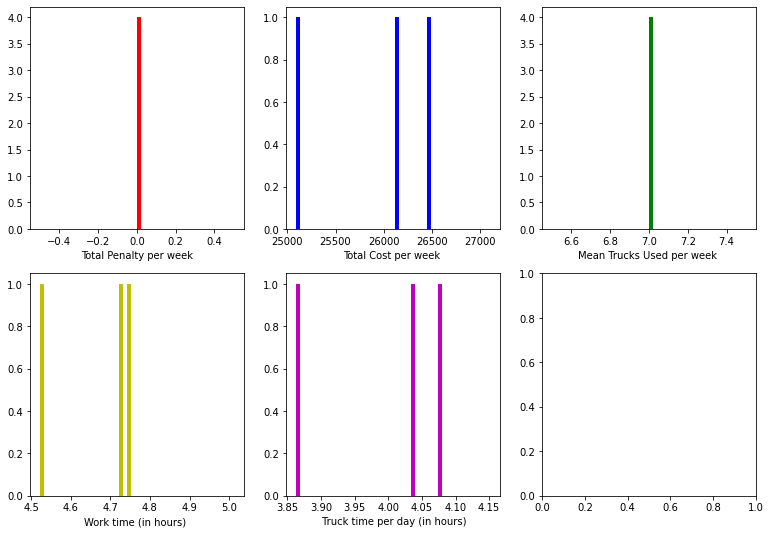




Your best option is: 1


<Figure size 432x288 with 0 Axes>

In [ ]:

instancia = 10 #10 or 25 or 70
iteration = 4 #number of iterations 
schedule = 6 #number of days 
AM_trucks = 53 #how many AM_trucks do you want to send 


opt_schedule=Grand_route_generator(instancia, iteration, schedule, AM_trucks)


##Consulting the optimal schedule

In [ ]:
#Consulting the truck's schedules. The format is: opt_schedule[day][truck]
opt_schedule[0][6]